In [4]:
import os
import numpy as np

Number of images for digit 0: 5923


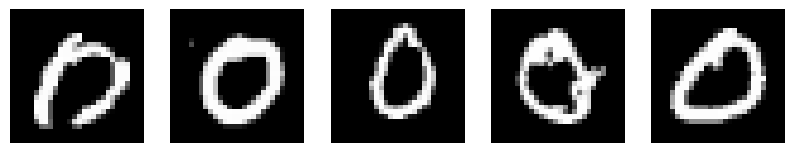

Number of images for digit 1: 6742


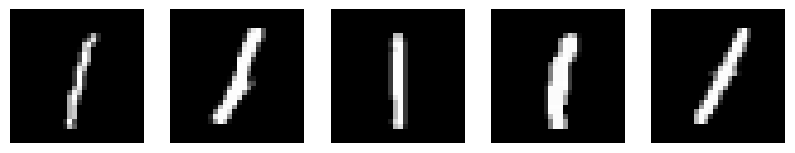

Number of images for digit 2: 5958


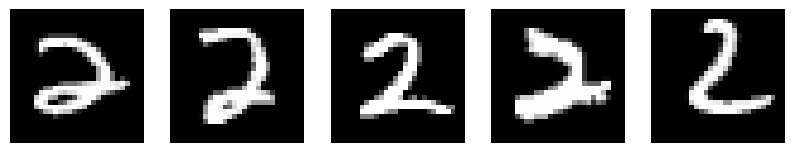

Number of images for digit 3: 6131


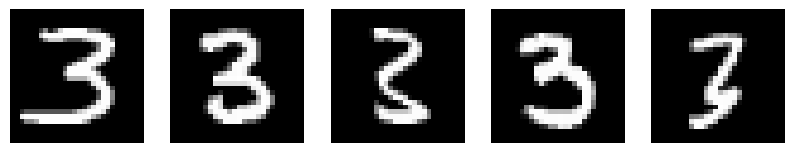

Number of images for digit 4: 5842


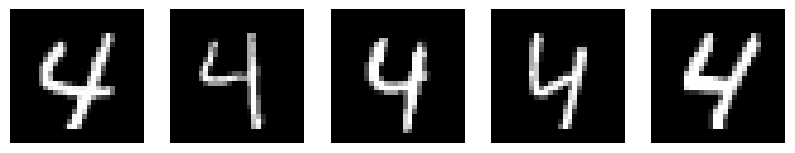

Number of images for digit 5: 5421


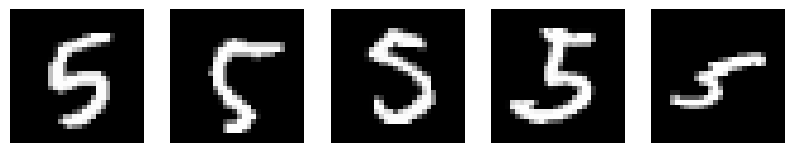

Number of images for digit 6: 5918


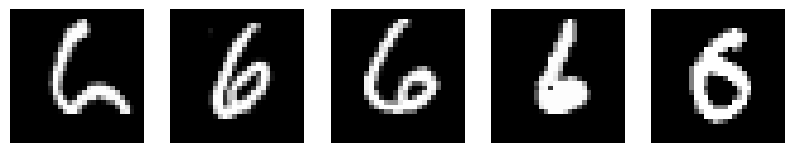

Number of images for digit 7: 6265


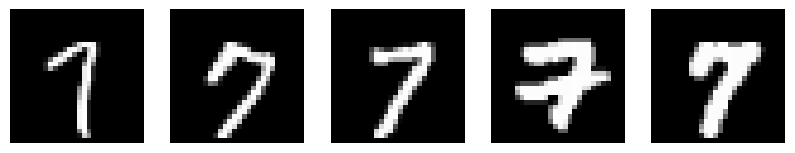

Number of images for digit 8: 5851


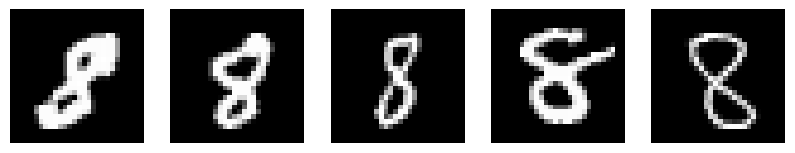

Number of images for digit 9: 5949


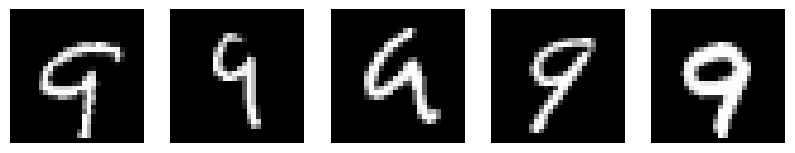

In [ ]:
import tempfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

DATASET_PATH = "/media/data/Downloads/mnist_png"
TEMP_DIR = tempfile.gettempdir()
TRAIN_DATA_TENSOR_PATH = os.path.join(TEMP_DIR, 'mnist_train_data.pt')
TRAIN_TARGETS_TENSOR_PATH = os.path.join(TEMP_DIR, 'mnist_train_targets.pt')
TEST_DATA_TENSOR_PATH = os.path.join(TEMP_DIR, 'mnist_test_data.pt')
TEST_TARGETS_TENSOR_PATH = os.path.join(TEMP_DIR, 'mnist_test_targets.pt')

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = mpimg.imread(os.path.join(folder, filename))
            images.append(img)
    return images

for digit in range(10):
    digit_path = os.path.join(DATASET_PATH, 'training', str(digit))
    print(f"Number of images for digit {digit}: {len(os.listdir(digit_path))}")
    
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for ax in axes:
        ax.imshow(mpimg.imread(os.path.join(digit_path, np.random.choice(os.listdir(digit_path)))), cmap='gray')
        ax.axis('off')
    plt.show()



# Define a custom dataset class
class MNISTDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, device='cpu'):
        self.device = device
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        if self.train:
            self.data_dir = os.path.join(root_dir, 'training')
            self.data_tensor_path = TRAIN_DATA_TENSOR_PATH
            self.targets_tensor_path = TRAIN_TARGETS_TENSOR_PATH
        else:
            self.data_dir = os.path.join(root_dir, 'testing')
            self.data_tensor_path = TEST_DATA_TENSOR_PATH
            self.targets_tensor_path = TEST_TARGETS_TENSOR_PATH
            
        self.classes = sorted(os.listdir(self.data_dir))  # Get class names (0, 1, etc.)
        self.image_paths = []
        self.labels = []

        if os.path.exists(self.data_tensor_path) and os.path.exists(self.targets_tensor_path):
            self.data = torch.load(self.data_tensor_path)
            self.targets = torch.load(self.targets_tensor_path)
        else:
            for i, class_name in enumerate(self.classes):
                class_dir = os.path.join(self.data_dir, class_name)
                for filename in os.listdir(class_dir):
                    if filename.endswith(".png"):
                        self.image_paths.append(os.path.join(class_dir, filename))
                        self.labels.append(i)  # Assign numerical label based on class index

            images = []
            for image_path in self.image_paths:
                image = Image.open(image_path).convert('L')  # Open image as grayscale
                if self.transform:
                    image = self.transform(image)
                images.append(image)
            
            self.data = torch.stack(images).float()
            self.targets = torch.tensor(self.labels).long()
            torch.save(self.data, self.data_tensor_path)
            torch.save(self.targets, self.targets_tensor_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Create the training dataset
mnist_train_dataset = MNISTDataset(root_dir=DATASET_PATH, train=True, transform=transform)

# Create the testing dataset
mnist_test_dataset = MNISTDataset(root_dir=DATASET_PATH, train=False, transform=transform)

# Create a dataloader for training
train_dataloader = DataLoader(mnist_train_dataset, batch_size=128, shuffle=True, prefetch_factor=3, num_workers=10, pin_memory=True)

# Create a dataloader for testing
test_dataloader = DataLoader(mnist_test_dataset, batch_size=32, shuffle=False, pin_memory=True)


In [9]:
import math
import umap
from typing import List
import pytorch_lightning as pl
from torchmetrics import Accuracy

import torch.nn as nn
import torch.nn.functional as F

plt.style.use('default')

class TrackingCallback(pl.Callback):
    def __init__(self, num_images=4):
        super().__init__()
        self.num_images = num_images

    def on_train_start(*args, **kwargs):
        print("registered TrackingCallback")

    # =========================
    # CUSTOM VALIDATION ROUTINE
    # =========================
    def on_train_epoch_start(self, trainer, pl_module):
        
        # disable the clustering
        pl_module.factor_cluster = 0.0
        
        pl_module.eval()
        
        # PREDICT VALIDATION ELEMENTS
        # ---------------------------
        
        results: List[dict] = []
        for data, labels in test_dataloader:
            result: dict = pl_module(data)
            
            batch_size = data[0].shape[0]
            for b in range(batch_size):
                _result = {}
                for key in result:
                    _result[key] = result[key][b].detach().cpu().numpy()
                    
                _result['label'] = labels[b].item()
                results.append(_result)
                
        print(f'[*] predicted {len(results)} test elements')
        for result in results:
            cluster_index = pl_module.evaluate_cluster(result['clustering'])
            #print('clustering', cluster_index, result['clustering'])
            result['cluster'] = cluster_index
            
        # PREDICTING THE CLUSTER ASSIGNMENT
        # ---------------------------------
            
        for c in range(pl_module.num_clusters):
            cluster_results = [r for r in results if r['cluster'] == c]
            print(f'\ncluster {c}')
            print(f' - num elements: {len(cluster_results)}')
            label_counts = {}
            for r in cluster_results:
                label = r['label']
                if label not in label_counts:
                    label_counts[label] = 0
                label_counts[label] += 1

            # Sort the labels by their counts in descending order
            sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

            # Get the total number of elements in the cluster
            total_elements = len(cluster_results)

            # Print the percentage of the three most occurring labels
            print(f' - Top 3 labels:')
            for i in range(min(3, len(sorted_labels))):
                label, count = sorted_labels[i]
                percentage = (count / total_elements) * 100
                print(f'   - Label {label}: {percentage:.2f}%')
                
        # UMAP VISUALIZATION EMBEDDINGS
        # -----------------------------
                
        print('[*] creating UMAP visualization...')
        embeddings = np.array([r['embedding'] for r in results])
        labels = np.array([r['label'] for r in results])
        # UMAP embedding
        reducer = umap.UMAP(n_neighbors=50, min_dist=0.0, random_state=42)
        embedding = reducer.fit_transform(embeddings)

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=25)

        # Add a legend
        plt.colorbar(scatter)

        # Add labels and title
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.title(f'Epoch {trainer.current_epoch}\n'
                  f'UMAP Visualization of Embeddings')

        # Show the plot
        plt.show()
        
        pl_module.train()


class ResBlock(nn.Module):
    
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # self.conv3 = nn.Conv2d(64, 256, kernel_size=1, padding=0)
        # self.bn3 = nn.BatchNorm2d(256)
        self.activation = nn.SiLU()
    
    def forward(self, x): 
        
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # x = self.activation(x)
        # x = self.conv3(x)
        # x = self.bn3(x)
        x += residual
        x = self.activation(x)
        
        return x


class MNISTModel(pl.LightningModule):
    
    def __init__(self, 
                 input_shape: List[int],
                 conv_units: List[int] = [256, 256, 256, 256],
                 proj_units: List[int] = [128, 1024],
                 dense_units: List[int] = [10],
                 num_clusters: int = 16,
                 pooling_size: int = 2,
                 factor_prediction: float = 0.0,
                 factor_contrastive: float = 1.0,
                 factor_cluster: float = 0.0,
                 learning_rate: float = 1e-4,
                 ):
        super().__init__()
        self.input_shape = input_shape
        self.in_channels, self.in_width, self.in_height = input_shape
        self.factor_prediction = factor_prediction
        self.factor_contrastive = factor_contrastive
        self.factor_cluster = factor_cluster
        self.num_clusters = num_clusters
        assert math.log2(num_clusters).is_integer(), "num_clusters must be a power of 2"
        self.cluster_depth = int(math.log2(num_clusters))
        self.learning_rate = learning_rate
        
        # ~ convolutional layers
        # Dynamically create convolutional layers
        self.conv_layers = nn.ModuleList()
        
        # prev_units = self.in_channels
        # for units in conv_units:
        #     self.conv_layers.append(nn.Sequential(
        #         nn.Conv2d(prev_units, units, kernel_size=3, padding=1),
        #         nn.BatchNorm2d(units),
        #         nn.SiLU(),
        #         nn.MaxPool2d(kernel_size=pooling_size)
        #     ))
        #     prev_units = units
        
        self.conv_layers.append(nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
        ))
        self.conv_layers.append(ResBlock())
        self.conv_layers.append(ResBlock())
        self.conv_layers.append(nn.MaxPool2d(kernel_size=pooling_size))
        self.conv_layers.append(ResBlock())
        self.conv_layers.append(ResBlock())
        self.conv_layers.append(nn.MaxPool2d(kernel_size=pooling_size))

        # Calculate the size of the flattened layer after the convolutional layers
        # self.flatten_size = (
        #     prev_units * \
        #     (self.in_width // (pooling_size ** len(conv_units))) * \
        #     (self.in_height // (pooling_size ** len(conv_units)))       
        # )
        self.flatten_size = 64 * (self.in_width // 4) * (self.in_height // 4)
 
        # ~ prediction layers
        self.dense_layers = nn.ModuleList()
        prev_units = self.flatten_size
        for c, units in enumerate(dense_units, start=1):
            if c == len(dense_units):
                lay = nn.Linear(prev_units, units)
            else:
                lay = nn.Sequential(
                    nn.Linear(prev_units, units),
                    nn.BatchNorm1d(units),
                    nn.SiLU()
                )
            self.dense_layers.append(lay)
            prev_units = units
            
        # ~ projection layers
        self.projection_layers = nn.ModuleList()
        prev_units = self.flatten_size
        for c, units in enumerate(proj_units):
            if c == len(dense_units):
                lay = nn.Linear(prev_units, units)
            else:
                lay = nn.Sequential(
                    nn.Linear(prev_units, units),
                    nn.BatchNorm1d(units),
                    nn.SiLU()
                )
            self.projection_layers.append(lay)
            prev_units = units
            
        # ~ clustering layers
        self.cluster_units = (2 ** (self.cluster_depth)) - 1
        print('num clusters', self.num_clusters, self.cluster_units)
        
        prev_units = self.flatten_size
        self.clustering_layer = nn.Sequential(
            nn.Linear(prev_units, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Linear(128, self.cluster_units),
        )

    def forward(self, x):
        
        # convolutions
        for lay in self.conv_layers:
            x = lay(x)
            
        x = x.view(x.size(0), -1)  # Flatten the tensor
        embedding = x
        #embedding = F.normalize(embedding, dim=1)
        
        # prediction
        output = embedding
        for lay in self.dense_layers:
            output = lay(output)
            
        # projection
        projection = embedding
        for lay in self.projection_layers:
            projection = lay(projection)
            
        # clustering
        clustering = self.clustering_layer(embedding)
        clustering = F.sigmoid(clustering)
            
        result = {
            'output': output,
            'embedding': embedding,
            'projection': projection,
            'clustering': clustering
        }
            
        return result
    
    def probability_vec_with_level(self, feature: torch.Tensor, level: int) -> torch.Tensor:
        prob_vec = torch.tensor([], requires_grad=True).to(self.device)
        for u in torch.arange(2 ** level - 1, 2**(level + 1) - 1, dtype=torch.long):
            probability_u = torch.ones_like(feature[:, 0], dtype=torch.float32).to(self.device)
            while (u > 0):
                if u/2 > torch.floor(u/2):
                    # go left
                    u = torch.floor(u/2).long()
                    probability_u *= feature[:, u]
                elif u/2 == torch.floor(u/2):
                    # go right
                    u = torch.floor(u/2).long()
                    probability_u *= 1.0 - feature[:, u]
            prob_vec = torch.cat((prob_vec, probability_u.unsqueeze(dim=1)), dim=1)
        
        return prob_vec
    
    def evaluate_cluster(self, clustering_tensor: torch.Tensor):
        
        values: List[int] = []
        
        # clustering_tensor: (num_clusters - 1, )
        start_index = 0
        node_index = 0
        local_index = 0
        
        for level in range(0, self.cluster_depth):
            value = clustering_tensor[node_index]
            value_binary = int(round(value))
            values.append(value_binary)
            
            start_index += 2 ** level
            local_index = int(2 * local_index + value_binary)
            node_index = int(start_index + local_index)
            
        #print('values', values)
        cluster_index = 0
        for i, value in enumerate(values):
            cluster_index += value * (2**(len(values) - 1 - i))
        
        #print('cluster_index', cluster_index)
        return cluster_index

    def training_step(self, batch, batch_idx):
        x, y = batch
        result = self(x)
        logits = result['output']
        
        # ~ prediction training
        loss = 0.0
        loss += self.factor_prediction * F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        # ~ contrastive training
        loss += self.factor_contrastive * self.training_contrastive(batch, batch_idx)
        
        return loss
    
    def training_contrastive(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch
        batch_size = x.shape[0]
        
        # Define a set of transformations
        transforms_list = [
            transforms.RandomRotation(degrees=10),  # Slight rotation
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.1)),  # Gaussian noise
            torch.roll,  # Circular translation (we'll parameterize this later)
            'noise',
        ]

        # Randomly select and apply a transformation to each image in the batch
        x_positive = []
        for i in range(batch_size):
            transform_idx = np.random.randint(len(transforms_list))
            transform = transforms_list[transform_idx]

            if transform == torch.roll:
                # Apply circular translation with a random shift
                shift_x = np.random.randint(-3, 3)
                shift_y = np.random.randint(-3, 3)
                x_positive.append(transform(x[i].unsqueeze(0), shifts=(shift_x, shift_y), dims=(1, 2)).squeeze(0))  # Apply to both dimensions
            elif transform == 'noise':
                # Add Gaussian noise
                noise = torch.randn_like(x[i]) * 0.1
                x_positive.append(x[i] + noise)
            else:
                x_positive.append(transform(x[i].unsqueeze(0)).squeeze(0))  # Apply transformation
        
        x_positive = torch.stack(x_positive)

        # Get embeddings for original and transformed images
        result = self(x)
        result_positive = self(x_positive)

        # Calculate InfoNCE loss
        
        tau = 1.0
        
        z = result['projection']
        z = F.normalize(z, dim=1)
        z_pos = result_positive['projection']
        z_pos = F.normalize(z_pos, dim=1)
        
        sim_pos = (z * z_pos).sum(dim=-1)
        sim_pos_exp = torch.exp(sim_pos / tau)
        
        sim_neg = (z.unsqueeze(dim=1) * z).unsqueeze(dim=0).sum(dim=-1)
        sim_neg_exp = torch.exp(sim_neg / tau).sum(dim=-1)
        
        loss = -torch.log(sim_pos_exp / sim_neg_exp).mean()

        self.log('contr_sim_pos', sim_pos.mean(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('contr_sim_neg', sim_neg.mean(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('contr_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
        
        # ~ clustering
        
        # regularization of the clustering layer to be equal probability of left and right
        # decision path
        loss_reg = F.binary_cross_entropy(result['clustering'], torch.ones_like(result['clustering']) * 0.5)
        loss += 1.0 * loss_reg
        self.log('loss_reg', loss_reg, on_step=True, on_epoch=True, prog_bar=True)
        
        EPS = 1e-8
        
        clust_sim_pos = 0.0
        clust_sim_neg = 0.0
        clust_loss = 0.0
        for level in range(1, self.cluster_depth):
            prob_features = self.probability_vec_with_level(result['clustering'], level)
            prob_features_positive = self.probability_vec_with_level(result_positive['clustering'], level)
            
            sim_pos = torch.sqrt((prob_features * prob_features_positive) + EPS).sum(dim=-1)
            clust_loss -= sim_pos.mean()
            clust_sim_pos += sim_pos.mean()
            
            sim_neg = torch.sqrt((prob_features.unsqueeze(dim=1) * prob_features) + EPS).unsqueeze(dim=0).sum(dim=-1)
            clust_loss += sim_neg.mean()
            clust_sim_neg += sim_neg.mean()
        
        loss += self.factor_cluster * clust_loss
        self.log('clust_loss', clust_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('clust_sim_pos', clust_sim_pos, on_step=True, on_epoch=True, prog_bar=True)
        self.log('clust_sim_neg', clust_sim_neg, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
                
    def validation_step(self, batch, batch_idx):
        x, y = batch
        result = self(x)
        logits = result['output']
        
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = Accuracy(task="multiclass", num_classes=10)(preds, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def configure_callbacks(self):
        return super().configure_callbacks() + [TrackingCallback()]

In [11]:


import torch

# Initialize the Model
model = MNISTModel(input_shape=[1, 28, 28])

# Initialize the Trainer
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')  # You can adjust the number of epochs

# Move model to GPU
model = model.to('cuda')

trainer.fit(model, train_dataloaders=train_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | conv_layers       | ModuleList | 297 K  | train
1 | dense_layers      | ModuleList | 31.4 K | train
2 | projection_layers | ModuleList | 533 K  | train
3 | clustering_layer  | Sequential | 403 K  | train
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.064     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


num clusters 16 15
Training: |          | 0/? [00:00<?, ?it/s]registered TrackingCallback
Epoch 0:   0%|          | 0/469 [00:00<?, ?it/s] 

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor